# LJ Tutorial 

Environment setup
```
git clone git@github.com:jennyfothergill/msibi.git
cd msibi
conda env create -f environment.yml
conda activate msibi
pip install -e .
```

In [1]:
import itertools

import freud
import gsd
import gsd.hoomd
import hoomd
import hoomd.md
import matplotlib.pyplot as plt
import mdtraj as md
import numpy as np

from msibi import MSIBI, State, Pair, mie

Remove old runs: only the rdf targets, run_template scripts, and the start.hoomdxml remain.

In [2]:
%%bash
rm -rf state*/_* rdfs/pair* potentials/* f_fits.log state*/log.txt state*/err.txt state*/run.py state*/query.dcd

Create the trajectories at the three statepoints... takes about 40 minutes on 2.2 GHz Intel Core i7.

In [3]:
kTs = [0.5, 1.5, 2.0]
n = 12
n_particles = n**3

In [4]:
# This cell takes 40 minutes. Don't uncomment and rerun it unless you have a good reason.
# trajectory{kT}.gsd files were created here

#for i,kT in enumerate(kTs):
#    hoomd.context.initialize("")
#    system = hoomd.init.create_lattice(
#        unitcell = (hoomd.lattice.sc(a=1.58, type_name="A")), 
#        n = n,
#    )
#    
#    nl = hoomd.md.nlist.cell()
#    lj = hoomd.md.pair.lj(r_cut=2.5, nlist=nl)
#    lj.pair_coeff.set('A', 'A', epsilon=1.0, sigma=1.0)
#    hoomd.md.integrate.mode_standard(dt=0.001)
#    _all = hoomd.group.all()
#    nvt = hoomd.md.integrate.nvt(group=_all, kT=kT, tau=1)
#    nvt.randomize_velocities(seed=23)
#    hoomd.analyze.log(
#        filename=f'state{i}/LJ_kT{kT}.log',
#        quantities=["time", "temperature", "potential_energy"],
#        period=100,
#        overwrite=True
#    )
#    hoomd.dump.gsd(f'state{i}/trajectory{kT}.gsd', period=5e3, group=_all, overwrite=True)
#    hoomd.run(1e6)

Check that the system is equilibrated.

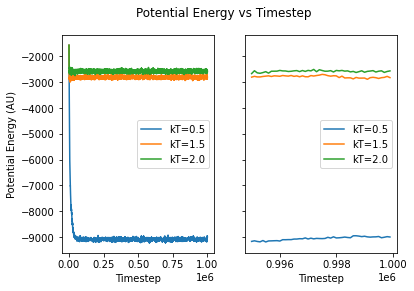

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.suptitle("Potential Energy vs Timestep")
for i, kT in enumerate(kTs):   
    log = np.loadtxt(f'state{i}/LJ_kT{kT}.log', skiprows=1)
    ax1.plot(log[:,0],log[:,3], label=f"kT={kT}")
    ax2.plot(log[-50:,0],log[-50:,3], label=f"kT={kT}")
    ax1.set_xlabel("Timestep")
    ax2.set_xlabel("Timestep")
    ax1.set_ylabel("Potential Energy (AU)")
    ax1.legend()
    ax2.legend()

Last 50 frames look equilibrated (TODO autocorrelation?), so we'll calculate the RDF and use those as our targets.

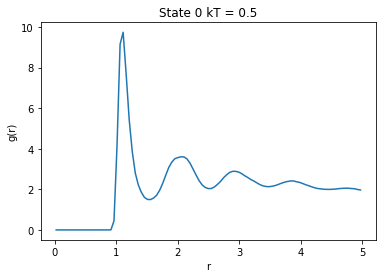

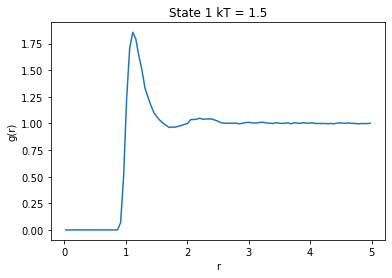

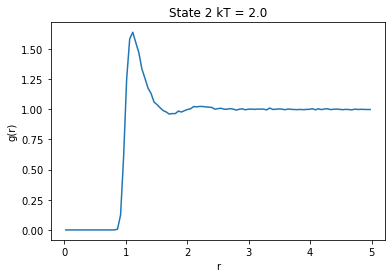

In [6]:
for i,kT in enumerate(kTs):
    gsdfile = f'state{i}/trajectory{kT}.gsd'
    with gsd.hoomd.open(gsdfile) as t:
        rdf = freud.density.RDF(bins=101, r_max=5)
        for snap in t[-50:]:
            rdf.compute(system=snap, reset=False)
        data = np.stack((rdf.bin_centers, rdf.rdf)).T
        np.savetxt(f"rdfs/rdftarget{i}", data)
        plt.plot(rdf.bin_centers, rdf.rdf)
        plt.title(f"State {i} kT = {kT}")
        plt.xlabel("r")
        plt.ylabel("g(r)")
        plt.show()

Set up global parameters:

- rdf_cutoff specifies how far out to calculate the rdf
- pot_cutoff specifies where to cut off the IBI calculation of the potential. The tail of the potential function (by default the last 5 points will be smoothed to zero using the [XPLOR smoothing function](https://hoomd-blue.readthedocs.io/en/stable/module-md-pair.html#hoomd.md.pair.pair). Small r values of the potential are also corrected using a linear correction by default. 
- smooth_rdfs if True, applies a Savitzky-Golay filter to the rdf array

In [7]:
rdf_cutoff = 5.0
opt = MSIBI(
    rdf_cutoff=rdf_cutoff, n_rdf_points=101, pot_cutoff=3.0, smooth_rdfs=True, verbose=True
)

Specify states

In [8]:
state0 = State(
    kT=0.5, 
    state_dir='./state0', 
    traj_file='trajectory0.5.gsd',
    name='state0', 
    backup_trajectory=True
)
state1 = State(
    kT=1.5, 
    state_dir='./state1', 
    traj_file='trajectory1.5.gsd',
    name='state1',
    backup_trajectory=True
)
state2 = State(
    kT=2.0, 
    state_dir='./state2', 
    traj_file='trajectory2.0.gsd',
    name='state2', 
    backup_trajectory=True
)
states = [state0, state1, state2]

Specify pairs

In [9]:
# all-all for n_particles atoms
# TODO use freud neighborlist?
# TODO write some logic to automate indices generation
indices = list(itertools.combinations(range(n_particles), 2))  

# 1-D array of potential values.
#TODO shouldn't this be boltzmann inverse?
initial_guess = mie(opt.pot_r, 1.0, 1.0)  # np array shape (61,)
rdf_targets = [
    np.loadtxt(f"rdfs/rdftarget{i}") for i in range(3)
]

pair0 = Pair('A', 'A', initial_guess)
alphas = [1.0, 1.0, 1.0]

/Users/jenny/Projects/msibi/msibi/potentials.py:42: RuntimeWarning: divide by zero encountered in true_divide
  return prefactor * eps * ((sig / r) ** m - (sig / r) ** n)
/Users/jenny/Projects/msibi/msibi/potentials.py:42: RuntimeWarning: invalid value encountered in subtract
  return prefactor * eps * ((sig / r) ** m - (sig / r) ** n)


Add targets to pair

In [10]:
for state, target, alpha in zip(states, rdf_targets, alphas):
    pair0.add_state(state, target, alpha, indices)
pairs = [pair0]  # optimize() expects a list of pairs

Implement MSIBI algorithm

Using HOOMD version 2.
-------- Iteration 0 --------
Launching 4 CPU threads...
    Running state state0 on CPU    Running state state1 on CPU

    Running state state2 on CPU
    Launched HOOMD in ./state0
    Launched HOOMD in ./state1
    Launched HOOMD in ./state2
    Finished in ./state2.
    Finished in ./state1.
    Finished in ./state0.


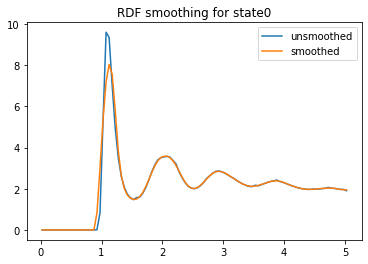

pair A-A, state state0, iteration 0: 0.969794


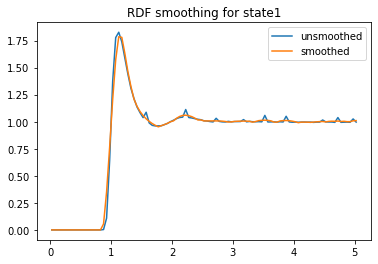

pair A-A, state state1, iteration 0: 0.991977


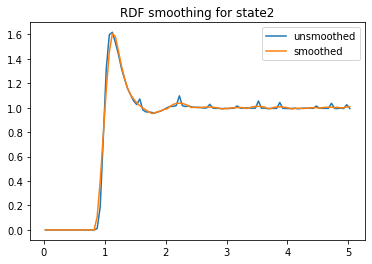

pair A-A, state state2, iteration 0: 0.992152


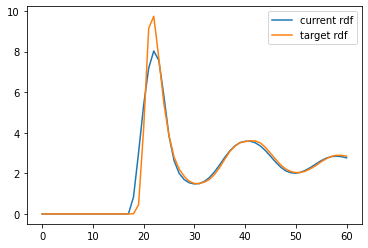

/Users/jenny/Projects/msibi/msibi/pair.py:214: RuntimeWarning: invalid value encountered in true_divide
  kT * alpha * np.log(current_rdf / target_rdf) / len(self.states)


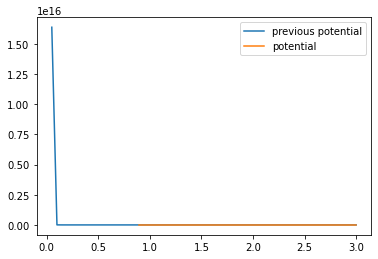

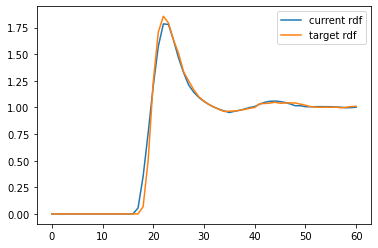

/Users/jenny/Projects/msibi/msibi/pair.py:214: RuntimeWarning: invalid value encountered in true_divide
  kT * alpha * np.log(current_rdf / target_rdf) / len(self.states)


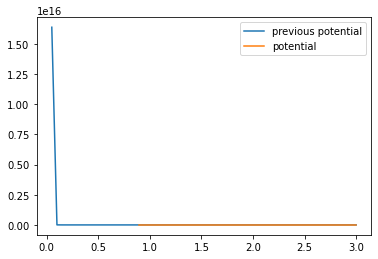

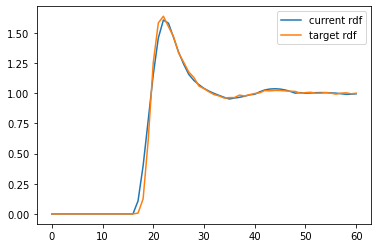

/Users/jenny/Projects/msibi/msibi/pair.py:214: RuntimeWarning: invalid value encountered in true_divide
  kT * alpha * np.log(current_rdf / target_rdf) / len(self.states)


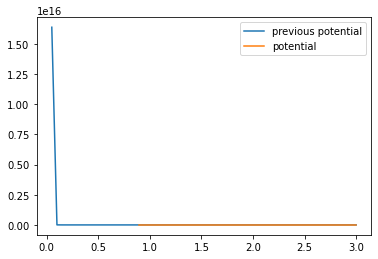

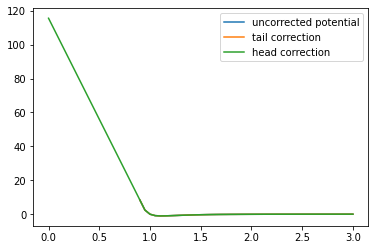

-------- Iteration 1 --------
Launching 4 CPU threads...
    Running state state1 on CPU    Running state state2 on CPU

    Launched HOOMD in ./state2
    Running state state0 on CPU    Launched HOOMD in ./state1

    Launched HOOMD in ./state0
    Finished in ./state2.
    Finished in ./state1.
    Finished in ./state0.


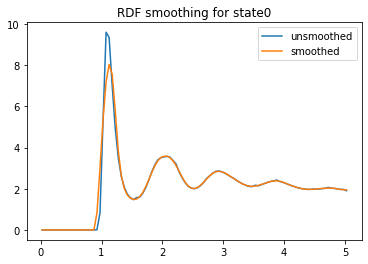

pair A-A, state state0, iteration 1: 0.969794


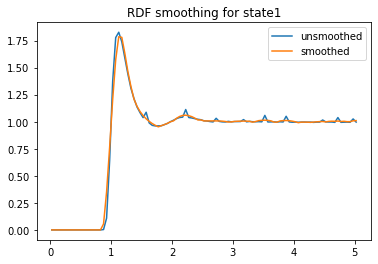

pair A-A, state state1, iteration 1: 0.991977


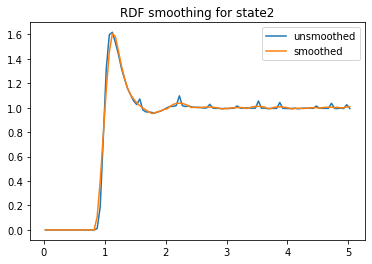

pair A-A, state state2, iteration 1: 0.992152


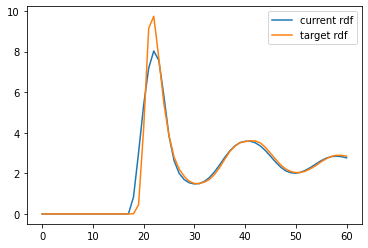

/Users/jenny/Projects/msibi/msibi/pair.py:214: RuntimeWarning: invalid value encountered in true_divide
  kT * alpha * np.log(current_rdf / target_rdf) / len(self.states)


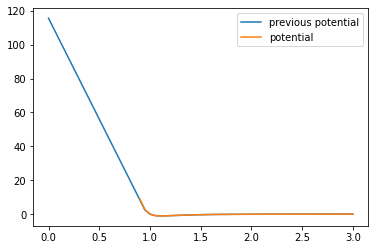

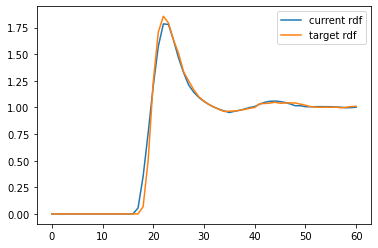

/Users/jenny/Projects/msibi/msibi/pair.py:214: RuntimeWarning: invalid value encountered in true_divide
  kT * alpha * np.log(current_rdf / target_rdf) / len(self.states)


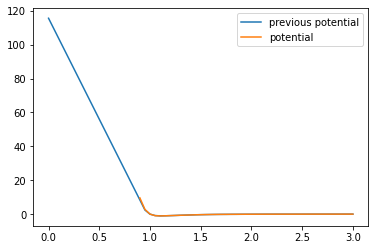

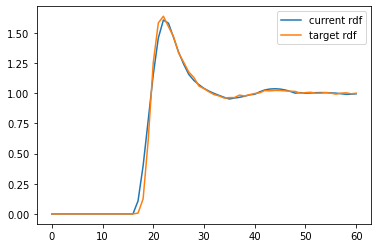

/Users/jenny/Projects/msibi/msibi/pair.py:214: RuntimeWarning: invalid value encountered in true_divide
  kT * alpha * np.log(current_rdf / target_rdf) / len(self.states)


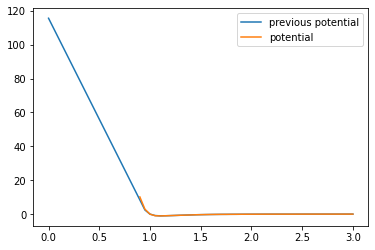

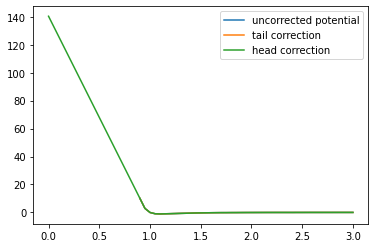

-------- Iteration 2 --------
Launching 4 CPU threads...
    Running state state0 on CPU    Running state state1 on CPU

    Launched HOOMD in ./state1    Running state state2 on CPU
    Launched HOOMD in ./state0

    Launched HOOMD in ./state2
    Finished in ./state2.
    Finished in ./state1.
    Finished in ./state0.


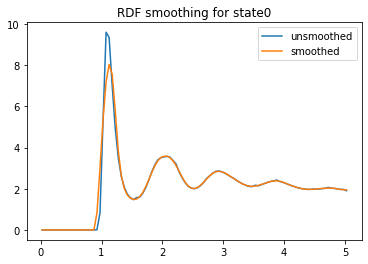

pair A-A, state state0, iteration 2: 0.969794


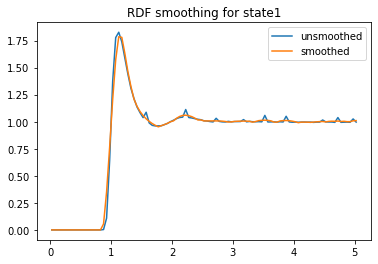

pair A-A, state state1, iteration 2: 0.991977


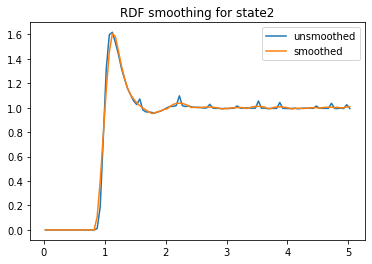

pair A-A, state state2, iteration 2: 0.992152


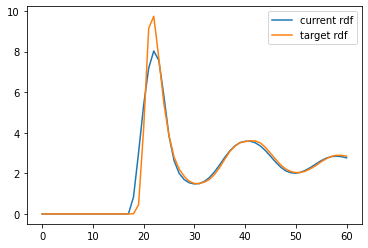

/Users/jenny/Projects/msibi/msibi/pair.py:214: RuntimeWarning: invalid value encountered in true_divide
  kT * alpha * np.log(current_rdf / target_rdf) / len(self.states)


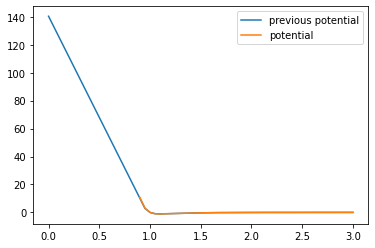

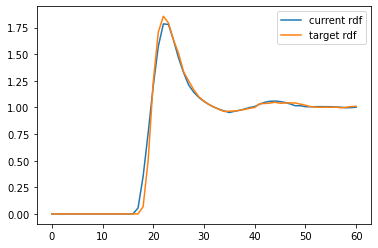

/Users/jenny/Projects/msibi/msibi/pair.py:214: RuntimeWarning: invalid value encountered in true_divide
  kT * alpha * np.log(current_rdf / target_rdf) / len(self.states)


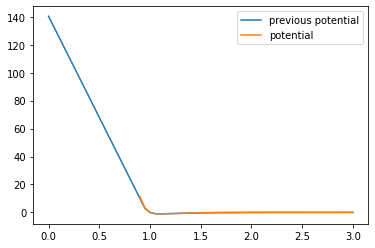

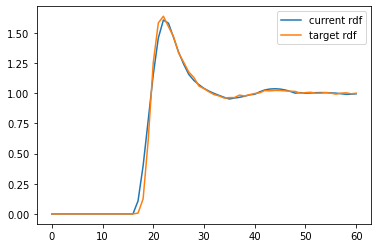

/Users/jenny/Projects/msibi/msibi/pair.py:214: RuntimeWarning: invalid value encountered in true_divide
  kT * alpha * np.log(current_rdf / target_rdf) / len(self.states)


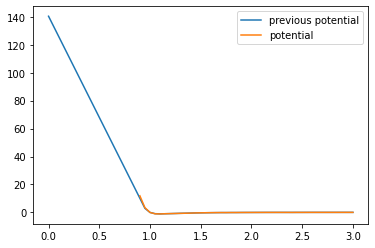

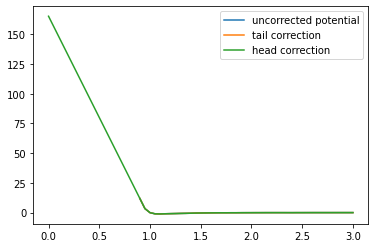

-------- Iteration 3 --------
Launching 4 CPU threads...
    Running state state0 on CPU
    Launched HOOMD in ./state0    Running state state2 on CPU

    Running state state1 on CPU
    Launched HOOMD in ./state2
    Launched HOOMD in ./state1
    Finished in ./state1.
    Finished in ./state2.
    Finished in ./state0.


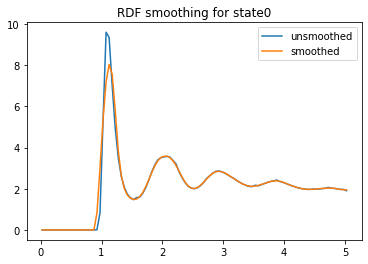

pair A-A, state state0, iteration 3: 0.969794


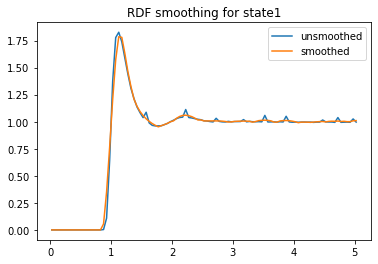

pair A-A, state state1, iteration 3: 0.991977


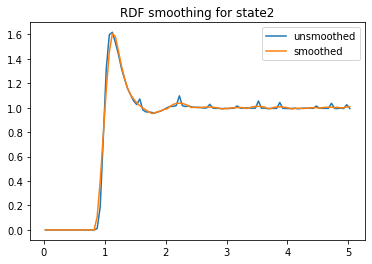

pair A-A, state state2, iteration 3: 0.992152


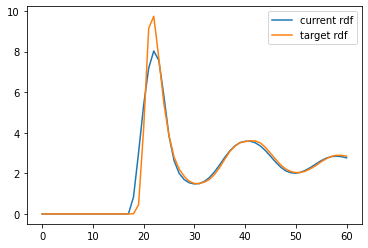

/Users/jenny/Projects/msibi/msibi/pair.py:214: RuntimeWarning: invalid value encountered in true_divide
  kT * alpha * np.log(current_rdf / target_rdf) / len(self.states)


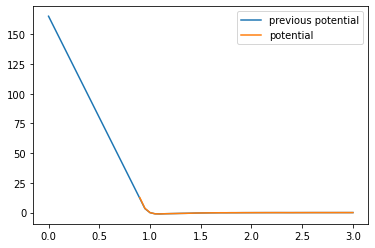

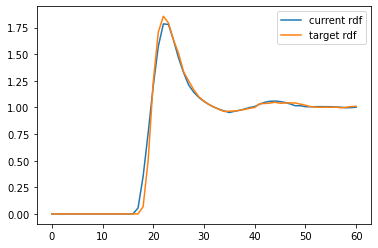

/Users/jenny/Projects/msibi/msibi/pair.py:214: RuntimeWarning: invalid value encountered in true_divide
  kT * alpha * np.log(current_rdf / target_rdf) / len(self.states)


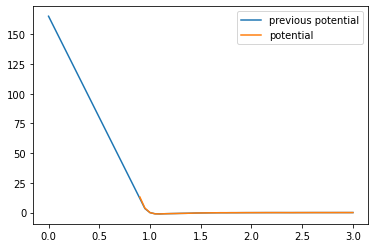

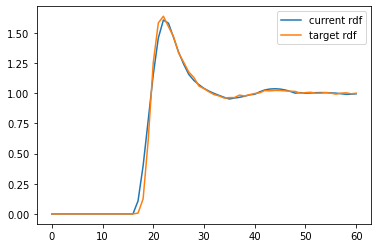

/Users/jenny/Projects/msibi/msibi/pair.py:214: RuntimeWarning: invalid value encountered in true_divide
  kT * alpha * np.log(current_rdf / target_rdf) / len(self.states)


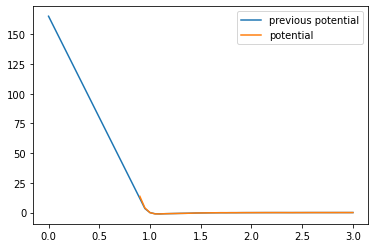

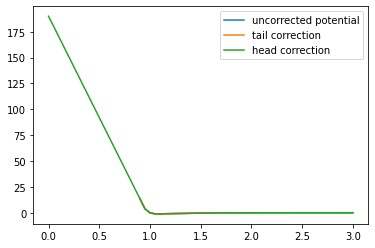

-------- Iteration 4 --------
Launching 4 CPU threads...
    Running state state0 on CPU    Running state state1 on CPU

    Launched HOOMD in ./state1    Running state state2 on CPU

    Launched HOOMD in ./state0    Launched HOOMD in ./state2

    Finished in ./state2.
    Finished in ./state1.
    Finished in ./state0.


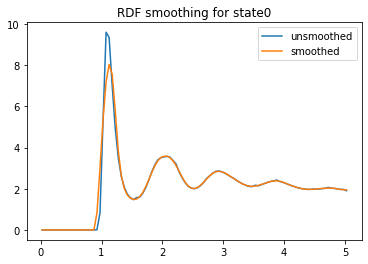

pair A-A, state state0, iteration 4: 0.969794


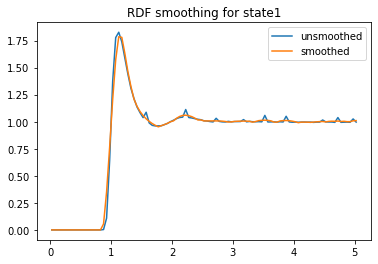

pair A-A, state state1, iteration 4: 0.991977


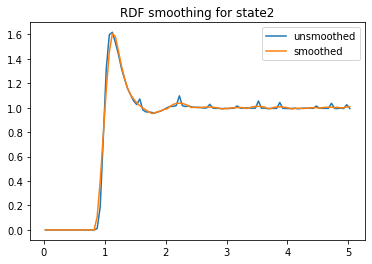

pair A-A, state state2, iteration 4: 0.992152


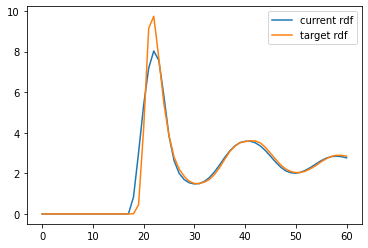

/Users/jenny/Projects/msibi/msibi/pair.py:214: RuntimeWarning: invalid value encountered in true_divide
  kT * alpha * np.log(current_rdf / target_rdf) / len(self.states)


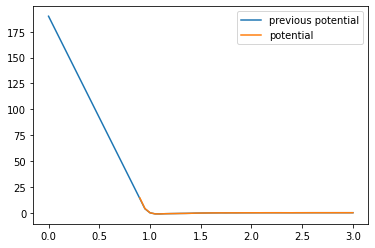

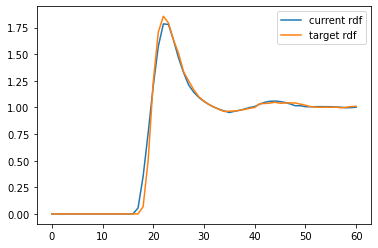

/Users/jenny/Projects/msibi/msibi/pair.py:214: RuntimeWarning: invalid value encountered in true_divide
  kT * alpha * np.log(current_rdf / target_rdf) / len(self.states)


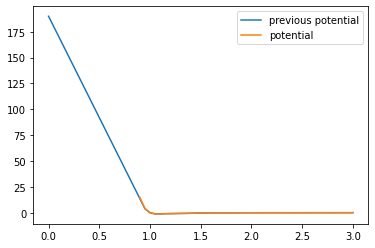

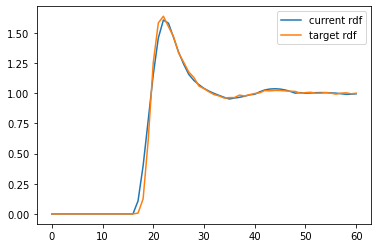

/Users/jenny/Projects/msibi/msibi/pair.py:214: RuntimeWarning: invalid value encountered in true_divide
  kT * alpha * np.log(current_rdf / target_rdf) / len(self.states)


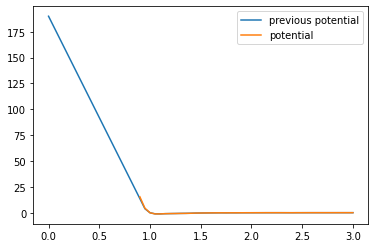

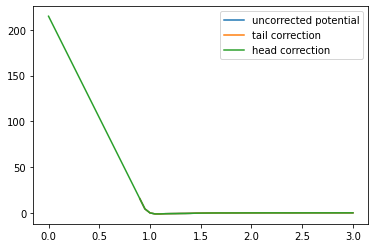

In [11]:
opt.optimize(states, pairs, n_iterations=5, engine='hoomd')

Plot results

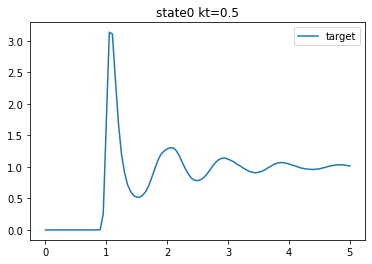

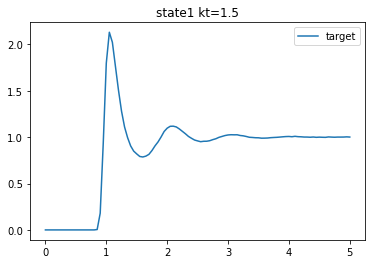

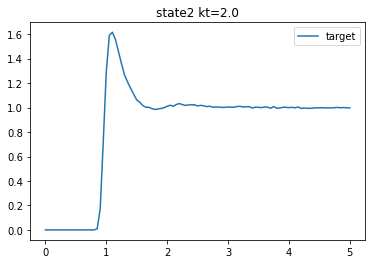

In [12]:
for state in states:
    plt.title(f'{state.name} kt={state.kT}')
    
    for step in range(0,opt.n_iterations):
        try:
            step_rdf = np.loadtxt(f'rdfs/pair_1-1-state_{state.name}-step{step}.txt')
            plt.plot(step_rdf[:,0],step_rdf[:,1], label=f'step {step}')
        except OSError:
            target = np.loadtxt(f'rdfs/rdf.target{state.name.strip("state")}.t1t1.txt')
            plt.plot(target[:,0], target[:,1], label='target')
            plt.legend()
            plt.show()
            break

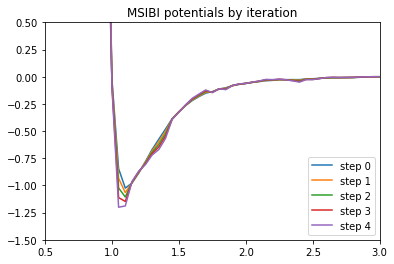

In [23]:
for step in range(0, opt.n_iterations):
    plt.ylim([-1.5,0.5])
    plt.xlim([0.5,3])
    plt.title("MSIBI potentials by iteration")
    try:
        step_pot = np.loadtxt(f'potentials/step{step}.pot.A-A.txt')
        plt.plot(step_pot[:,0],step_pot[:,1], label=f'step {step}')
    except OSError:
        break
plt.legend()
plt.show()